In [7]:
import os, re
import math 
import glob

from astropy.coordinates import cartesian_to_spherical
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, random_split, DataLoader
from typing import Any, Callable, Optional, Tuple

import pytorch_lightning as pl

from omegaconf import OmegaConf


import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from scipy.interpolate import griddata

In [71]:
# Define Model
# The model gets as an input a time-series of a regular and based on that, will do a super-resolution

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=None, name='Convolutional Encoder'):
        super(Encoder, self).__init__()
        
        self.id = 'encoder'
        
        if output_size==None:
            output_size=input_size
            
        self.encoder = nn.Sequential(
            nn.Conv2d(input_size,hidden_size, 3, padding=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_size),
            
            nn.Conv2d(hidden_size,hidden_size, 3, padding=(1,1), stride=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_size),
                                
            nn.Conv2d(hidden_size,output_size, 3, padding=(1,1), stride=(2,2)),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.encoder(input) 
    
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=None, name='Convolutional Decoder'):
        super(Decoder, self).__init__()
        
        self.id = 'decoder'
        
        if output_size==None:
            output_size=input_size       
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(input_size,hidden_size, 3, padding=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_size),
            
            nn.Conv2d(hidden_size,hidden_size, 3, padding=(1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_size),
            
            nn.Conv2d(hidden_size,output_size, 3, padding=(1,1)),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        return self.decoder(input) 
 
class TimeDistributed(nn.Module):
    def __init__(self, module, name='Time Distributed'):
        super(TimeDistributed, self).__init__()
        self.module = module
        
    def forward(self, input):
        batch_or_time1, batch_or_time2 = input.size(0), input.size(1)
        
        new_shape = list([batch_or_time1*batch_or_time2]) + list(input.shape[2:])
        input = self.module(input.reshape(new_shape))
        
        output_shape = list([batch_or_time1, batch_or_time2]) + list(input.shape[1:])
        return input.reshape(output_shape)  

class CLSTM_cell(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=(3,3), padding=(1,1), name='CLSTM-Cell'):
        
        super(CLSTM_cell, self).__init__()      
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.conv = nn.Conv2d(input_size + hidden_size, hidden_size*4, kernel_size, 1, padding)
        self.reset_parameters()
        
    def forward(self, input, H=None, C=None):
        self.check_forward_input(input)
        if H is None:
            H = torch.zeros(input.size(0), self.hidden_size, input.size(2), input.size(3),
                             dtype=input.dtype, device=input.device)
        if C is None:
            C = torch.zeros(input.size(0), self.hidden_size, input.size(2), input.size(3),
                             dtype=input.dtype, device=input.device)  

        conv_out = self.conv(torch.cat([input,H], dim=1)) # concatenate the features, [b, f_X+f_h, :, :] # [b, f_h,:,:]
        _f, _i, _c, _o = torch.split(conv_out, self.hidden_size, dim=1)
        
        f = torch.sigmoid(_f)
        i = torch.sigmoid(_i)
        c = torch.sigmoid(_c)
        o = torch.tanh(_o)
        
        C = C * f + i * c
        H = o * torch.tanh(c)
        return H, C

    def reset_parameters(self) -> None:
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def check_forward_input(self, input: Tensor) -> None:
        if input.size(1) != self.input_size:
            raise RuntimeError(
                "input has inconsistent input_size: got {}, expected {}".format(
                    input.size(1), self.input_size))                     

class CLSTM_layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=3, name='CLSTM-Layers'):
        super(CLSTM_layers, self).__init__()
            
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        cell_0 = [CLSTM_cell(input_size, hidden_size)]
        self.cells = nn.ModuleList(cell_0 + [CLSTM_cell(hidden_size, hidden_size) for i in range(1,num_layers)])
        
    def getShapedTensor(self, input, repeat_input=False):
        if repeat_input:
            return torch.zeros(input.size(0), self.hidden_size, input.size(2), input.size(3), dtype=input.dtype, device=input.device)
        else:
            return torch.zeros(input.size(0), self.hidden_size, input.size(3), input.size(4), dtype=input.dtype, device=input.device)

    def forward(self, input, H=None, C=None, return_sequence=False, repeat_input=False, output_sequence_length=8):
        # if return sequence: return all h's, 
        # else: returns last H and C
            
        if repeat_input:
            Hs = [self.getShapedTensor(input, True) for _ in range(output_sequence_length)]  
        else:
            Hs = [self.getShapedTensor(input) for _ in range(input.size(1))]  
        
        if not isinstance(H, type(None)):
            Hs[0] = H
        if isinstance(C, type(None)):
            C = self.getShapedTensor(input, repeat_input)
                
        if repeat_input: 
            for t in range(output_sequence_length):
                H, C = self.cells[0](input, H=H, C=C)
                Hs[t] = H
                
            for l in range(1, len(self.cells)):  
                for t in range(output_sequence_length):
                    if t==0:
                        C = self.getShapedTensor(input, repeat_input)
                    H, C = self.cells[l](Hs[t], H=H, C=C)
                    Hs[t] = H
        else:
            for t in range(input.size(1)): # numer of time-steps
                H, C = self.cells[0](input[:,t], H=H, C=C)
                Hs[t] = H
                
            for l in range(1, len(self.cells)):  
                for t in range(input.size(1)):
                    if t==0:
                        C = self.getShapedTensor(input, repeat_input)
                    H, C = self.cells[l](Hs[t], H=H, C=C)
                    Hs[t] = H  
        
        if return_sequence:
            return torch.stack(Hs).transpose(0,1) # [b,t,hd,:,:]
        #print(Hs[-1].shape)
        return Hs[-1], C# [b,hd,:,:], [b,hd,:,:], [b,hd,:,:]

class CLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=None, directional=1, name='CLSTM'):
        super(CLSTM, self).__init__()
        
        self.id = 'CLSTM'
        
        clstm_hidden_size=hidden_size
        
        if output_size==None:
            output_size = input_size

        self.encoder = TimeDistributed(Encoder(input_size, hidden_size, output_size=hidden_size))
        self.decoder = TimeDistributed(Decoder(clstm_hidden_size, hidden_size, output_size=output_size))
        
        self.encoder_clstm = CLSTM_layers(hidden_size,clstm_hidden_size, num_layers=3)      
        self.decoder_clstm = CLSTM_layers(clstm_hidden_size, clstm_hidden_size)


    def forward(self, input, max_depth=10):
        input = self.encoder(input)
        H, C = self.encoder_clstm(input, return_sequence=False)   
        input = self.decoder_clstm(H, H=H, C=C, return_sequence=True, repeat_input=True, output_sequence_length=max_depth)
        input = self.decoder(input)
        return input.transpose(1,2)


In [72]:
# Define Dataset

class HeartStaticDataset(Dataset):
    def __init__(self, config, sim_name='Scroll1', kind='V', mode='projection'):
        self.config = config 
        
        def atoi(text):
            return int(text) if text.isdigit() else text

        def natural_keys(text):
            return [atoi(c) for c in re.split(r'(\d+)', text)]
        
        if config.kind=='V':
            names = 'V_snap*'
        else:
            names = 'C_snap*'
            
        self.mode = mode
            
        basename = os.path.join(config.data_folder, names)
        self.files = glob.glob(basename)
        self.files.sort(key=natural_keys)
        
        self.surface = np.fromfile(self.config.surface_file, dtype=np.int32)
        #self.surface_inds = self.List2Vec(surface)
        
        self.outer_surface = np.load(self.config.outer_surface_file)
        self.outer_surface_inds = self.List2Vec(self.outer_surface)
        

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # mode can be: 'load_file', 'surface', 'projection'
        #return np.load(self.files[idx])
        
        # 1: Load file
        data = np.fromfile(self.files[idx], dtype=np.double)
        if self.config.mode=='load_file':
            return data
        
        # 2: Extract points to surface inds
        dense_pc = self.List2Vec(data*self.Vec2List(self.outer_surface_inds), return_values=True)
        if self.config.mode=='surface':
            return dense_pc
        
        # 3: Project to
        soff = np.mean(dense_pc[:,:3], axis=0)
        dense_pc_projected = self.get_spherical_projection(dense_pc[:,:3], *soff, 300)
            
        if self.config.mode=='projection':
            print('Projection')
            return dense_pc_projected, dense_pc[:,3]
       
        # Embeds the surface of the projected sphere onto a 2D-grid of latitude and longitude
        _, lat, lon = cartesian_to_spherical(dense_pc_projected[:,0], 
                                                 dense_pc_projected[:,1], 
                                                 dense_pc_projected[:,2])
        lat, lon = lat.value, lon.value
            
        if self.config.mode=='2dEmbedding':
            return lat, lon, dense_pc[:,3]
      
        l = len(lat)
        gx, gy = np.mgrid[0:1:382j, 0:1:382j]
            
        grid = griddata(np.array([lon, lat]).T, dense_pc[:,3], (gx,gy), method='nearest')
            
        if self.config.mode=='RegGridEmbedding':
            return grid
            
        return dense_pc
    
    def List2Vec(self, lst, return_values=False):
        vecs = np.reshape(lst, self.config.shape)
        pos = np.array(np.where(vecs!=0)).T.astype(np.int16)

        if return_values==False:
            return pos

        values = np.array([vecs[pos[:,0], pos[:,1],pos[:,2]]]).T
        return np.concatenate([pos, values], axis=1)

    def Vec2List(self, vecs):
        cube = np.zeros(self.config.shape)
        cube[vecs[:,0], vecs[:,1], vecs[:,2]] = 1
        lst = np.reshape(cube, -1)
        return lst
    
    def get_spherical_projection(self, coords,x0,y0,z0,r1):
        x2 = coords[:,0]
        y2 = coords[:,1]
        z2 = coords[:,2]
        x0 = x0 * np.ones(x2.size)
        y0 = y0 * np.ones(y2.size)
        z0 = z0 * np.ones(z2.size)
        r1 = r1 * np.ones(x2.size)
        r2 = np.power(np.square(x2-x0)+np.square(y2-y0)+np.square(z2-z0),0.5)
        x_new = x0 + (r1/r2) * (x2-x0) - x0
        y_new = y0 + (r1/r2) * (y2-y0) - y0
        z_new = z0 + (r1/r2) * (z2-z0) - z0
        return np.array([x_new,y_new,z_new]).T
    
    def cart2pol(self, x, y, z):
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        return(rho, phi)

class HeartDataModule(pl.LightningDataModule):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        
    def prepare_data(self):
        pass

    def setup(self, stage=None):
        dataset = BarkleyDataset(self.config.dataset_dir, 
                                 time_steps=self.config.time_step, 
                                 depth=self.config.depth)
        print(dataset)
        
        n_train = int(len(dataset)*0.95+0.5)
        n_val = int(len(dataset)*0.05+0.5)
        
        self.train_dataset, self.val_dataset = random_split(dataset, [n_train, n_val])   
        
    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.config.batch_size, num_workers=4, shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.val_dataset, batch_size=self.config.batch_size, num_workers=4, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(self.val_dataset, batch_size=self.config.batch_size, num_workers=4, shuffle=False)
        return test_loader
    
# Define Dataset

class HeartDynamicDataset(Dataset):
    def __init__(self, config, kind='V', mode='projection'):
        self.config = config 
        
        
        if config.kind=='V':
            self.names = 'V_snap*'
        else:
            self.names = 'C_snap*'
            
        self.mode = mode
        
        self.folders = glob.glob(os.path.join(config.data_folder, 'Scroll*', ''))
        self.surface = np.fromfile(self.config.surface_file, dtype=np.int32)
        
        self.outer_surface = np.load(self.config.outer_surface_file)
        self.outer_surface_inds = self.List2Vec(self.outer_surface)
        
        self.transform = lambda data:((torch.tensor(data).float()+127)/255.).unsqueeze(1)
        self.target_transform = lambda data:((torch.tensor(data).float()+127)/255.).unsqueeze(0).unsqueeze(0)
        
    def atoi(self, text):
        return int(text) if text.isdigit() else text

    def natural_keys(self, text):
        return [self.atoi(c) for c in re.split(r'(\d+)', text)]
        

    def __len__(self):
        return len(self.folders)
    
    def loadFile(self, file):
        data = np.fromfile(file, dtype=np.double)
        dense_pc = self.List2Vec(data*self.Vec2List(self.outer_surface_inds), return_values=True)
        soff = np.mean(dense_pc[:,:3], axis=0)
        dense_pc_projected = self.get_spherical_projection(dense_pc[:,:3], *soff, 300)
        _, lat, lon = cartesian_to_spherical(dense_pc_projected[:,0], 
                                                 dense_pc_projected[:,1], 
                                                 dense_pc_projected[:,2])
        lat, lon = lat.value, lon.value
      
        l = len(lat)
        gx, gy = np.mgrid[0:1:382j, 0:1:382j]
        grid = griddata(np.array([lon, lat]).T, dense_pc[:,3], (gx,gy), method='nearest')
        
        return grid

    def __getitem__(self, idx):
        folder = self.folders[idx]
        files = glob.glob(os.path.join(folder, self.names))
        files.sort(key=self.natural_keys)
        start_ind = np.random.randint(0,len(files)-self.config.time_steps)
        
        data = []
        for i in range(start_ind, start_ind+self.config.time_steps):
            grid = self.loadFile(files[i])
            data.append(grid)
        data = np.array(data)
        
        return self.transform(data[:,::self.config.ds, ::self.config.ds]), self.target_transform(data[-1])
    
    def List2Vec(self, lst, return_values=False):
        vecs = np.reshape(lst, self.config.shape)
        pos = np.array(np.where(vecs!=0)).T.astype(np.int16)

        if return_values==False:
            return pos

        values = np.array([vecs[pos[:,0], pos[:,1],pos[:,2]]]).T
        return np.concatenate([pos, values], axis=1)

    def Vec2List(self, vecs):
        cube = np.zeros(self.config.shape)
        cube[vecs[:,0], vecs[:,1], vecs[:,2]] = 1
        lst = np.reshape(cube, -1)
        return lst
    
    def get_spherical_projection(self, coords,x0,y0,z0,r1):
        x2 = coords[:,0]
        y2 = coords[:,1]
        z2 = coords[:,2]
        x0 = x0 * np.ones(x2.size)
        y0 = y0 * np.ones(y2.size)
        z0 = z0 * np.ones(z2.size)
        r1 = r1 * np.ones(x2.size)
        r2 = np.power(np.square(x2-x0)+np.square(y2-y0)+np.square(z2-z0),0.5)
        x_new = x0 + (r1/r2) * (x2-x0) - x0
        y_new = y0 + (r1/r2) * (y2-y0) - y0
        z_new = z0 + (r1/r2) * (z2-z0) - z0
        return np.array([x_new,y_new,z_new]).T
    
    def cart2pol(self, x, y, z):
        rho = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y, x)
        return(rho, phi)
    

In [84]:
config = dict(data_folder='../data/raw/',
              surface_file='../data/processed/Heart_surface',
              outer_surface_file='../data/processed/outer_surface.npy',
              shape=(320,303,228),
              sim_name='Scroll1',
              kind='V',
              mode='RegGridEmbedding',
              dataset='dynamic',
              time_steps=8,
              ds = 16
             )
config = OmegaConf.create(config)

In [85]:
dataset = HeartDynamicDataset(config)

In [86]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [87]:
X, y = next(iter(dataloader))
X.shape

torch.Size([1, 8, 1, 24, 24])

In [78]:
model = CLSTM(1,64)

In [79]:
with torch.no_grad():
    y_pred = model(X, max_depth=1)

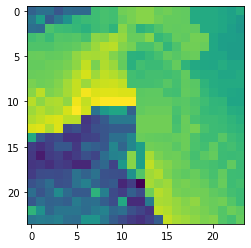

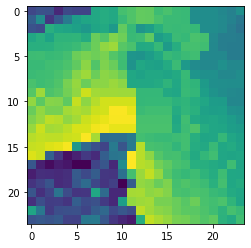

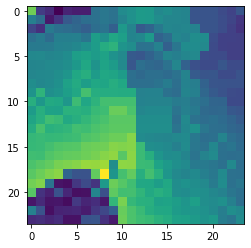

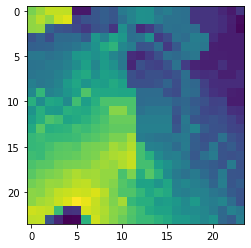

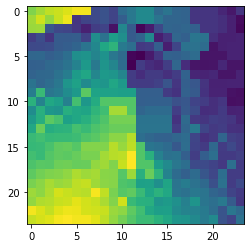

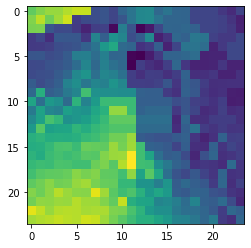

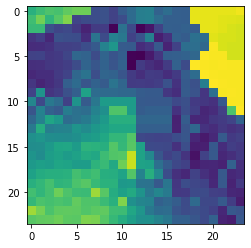

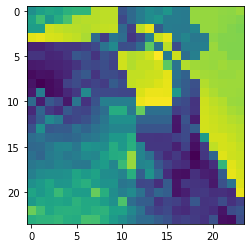

In [82]:
for i in range(8):
    plt.imshow(X[0,i,0,:,:])
    plt.show()

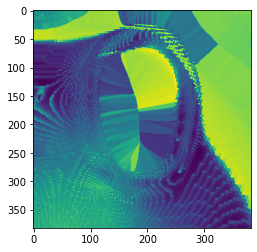

In [83]:
plt.imshow(y[0,0,0,:,:])
plt.show()

In [5]:
dataset = HeartStaticDataset(config)

.........Done!


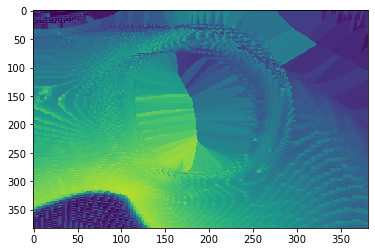

In [140]:
import matplotlib.animation as animation
import random

fps = 10
frames = 80
snapshots = [dataset[i] for i in range(frames)]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=-84.65, vmax=10.18)

def animate_func(i):
    if i % fps == 0:
        print('.', end ='')

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(fig, animate_func, 
                               frames = frames, interval = 1000/fps)

anim.save('test_anim.mp4', fps=fps)# , extra_args=['-vcodec', 'libx264'])

print('Done!')

# plt.show()  # Not required, it seems!

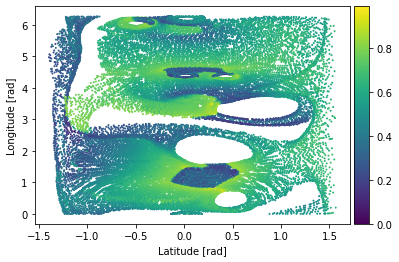

In [64]:
#rho, theta, V = dataset[0]
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()

_min, _max = V.min(), V.max()
Vdata = (V[::4]-_min)/(V.max()-V.min())

im = ax.scatter(rho[::4], theta[::4], c=Vdata, s=1)
ax.set_xlabel('Latitude [rad]'), ax.set_ylabel('Longitude [rad]')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)
#cbar.ax.set_xticklabels(['$V_{\text{min}}$', '$V_{\text{max}}$'])  # horizontal colorbar

#cbar = fig.colorbar(im, ticks=[V.min(), V.max()])
#plt.title('Latitude and Longitude on the projected sphere')
plt.savefig('latlon.pdf', dpi=300)

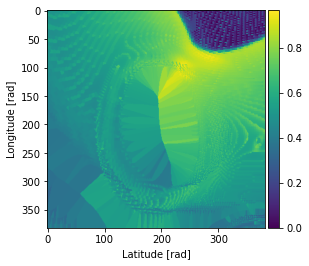

In [76]:
from scipy import ndimage, misc

fig, ax = plt.subplots()

data = ndimage.rotate(dataset[0], 270)

_min, _max = data.min(), data.max()
Vdata = (data-_min)/(V.max()-V.min())

im = ax.imshow(ndimage.rotate(Vdata, 270))
ax.set_xlabel('Latitude [rad]'), ax.set_ylabel('Longitude [rad]')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im, cax=cax)



#plt.imshow(ndimage.rotate(dataset[0], 270))
#ax.set_xticks(np.linspace(0, 382, 7), np.linspace(-1.5, 1.5, 7))
#ax.set_yticks(np.linspace(0, 382, 7), np.linspace(6, 0, 7))

#plt.xlabel('Latitude [rad]'), plt.ylabel('Longitude [rad]')
plt.savefig('reggrid.pdf', dpi=300)